<a href="https://colab.research.google.com/github/OlhaZahrebelna/python_for_ds_task/blob/main/Zahrebelna_Olha_%22HW_2_2_%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_%D0%B7_scikit_learn_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay,PrecisionRecallDisplay, average_precision_score, ConfusionMatrixDisplay
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
import os

In [2]:
df = pd.read_csv('/content/train.csv')
df = df.reset_index(drop=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [4]:
target_col = "Exited"
group_col = "CustomerId"

input_cols = [c for c in df.columns if c not in [target_col, group_col, "Surname"]]

# Client stratified
cust_y = (
    df.groupby(group_col, as_index=False)[target_col]
      .max()
      .rename(columns={target_col: "cust_target"})
)

In [5]:
train_ids, val_ids = train_test_split(
    cust_y[group_col],
    test_size=0.2,
    random_state=42,
    stratify=cust_y["cust_target"]
)

train_ids = set(train_ids)
val_ids = set(val_ids)

train_df = df[df[group_col].isin(train_ids)].copy()
val_df   = df[df[group_col].isin(val_ids)].copy()

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [6]:
train_inputs  = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs    = val_df[input_cols]
val_targets   = val_df[target_col]

# sanity checks
assert set(train_df[group_col]).isdisjoint(set(val_df[group_col])), "CustomerId leakage!"
print(train_inputs.shape, val_inputs.shape)
print("Exited mean (rows):", train_targets.mean(), val_targets.mean())

(12022, 11) (2978, 11)
Exited mean (rows): 0.20370986524704707 0.2024848891873741


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [7]:
categorical_cols = train_inputs.select_dtypes(include=['object']).columns.tolist()
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()

In [8]:
categorical_cols, numeric_cols

(['Geography', 'Gender'],
 ['id',
  'CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'])

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [9]:
numeric_cols_model = [c for c in numeric_cols if c != 'id']

In [10]:
assert train_inputs[categorical_cols + numeric_cols_model].isna().sum().sum() == 0
assert val_inputs[categorical_cols + numeric_cols_model].isna().sum().sum() == 0


In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols_model),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ],
    remainder="drop"
)

X_train = preprocessor.fit_transform(train_inputs)
X_val   = preprocessor.transform(val_inputs)

feature_names = preprocessor.get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=feature_names, index=train_inputs.index)
X_val   = pd.DataFrame(X_val,   columns=feature_names, index=val_inputs.index)

display(X_train.head(5))
display(X_val.head(5))


,num__CreditScore,num__Age,num__Tenure,num__Balance,num__NumOfProducts,num__HasCrCard,num__IsActiveMember,num__EstimatedSalary,cat__Geography_France,cat__Geography_Germany,cat__Geography_Spain,cat__Gender_Female,cat__Gender_Male
0,0.261999,-1.069000,-0.368212,-0.716611,2.647681,0.520021,-0.973565,1.372845,1.0,0.0,0.0,0.0,1.0
1,0.386687,-0.456586,-1.447532,-0.716611,0.771219,-1.923000,1.027153,-1.178610,1.0,0.0,0.0,1.0,0.0
2,0.317416,1.748107,0.351334,-0.716611,2.647681,-1.923000,-0.973565,1.351661,1.0,0.0,0.0,1.0,0.0
3,1.301068,0.768244,0.351334,0.678844,0.771219,0.520021,-0.973565,0.953339,0.0,1.0,0.0,0.0,1.0
4,-1.594471,2.115556,-1.807305,1.087371,-1.105242,0.520021,-0.973565,1.284540,0.0,1.0,0.0,1.0,0.0


,num__CreditScore,num__Age,num__Tenure,num__Balance,num__NumOfProducts,num__HasCrCard,num__IsActiveMember,num__EstimatedSalary,cat__Geography_France,cat__Geography_Germany,cat__Geography_Spain,cat__Gender_Female,cat__Gender_Male
11,0.719189,4.075283,1.070880,-0.716611,-1.105242,0.520021,-0.973565,1.292035,1.0,0.0,0.0,1.0,0.0
25,-0.209046,-0.946518,-0.008439,-0.716611,0.771219,0.520021,1.027153,1.266390,1.0,0.0,0.0,0.0,1.0
28,0.109602,-0.946518,-0.008439,1.369134,-1.105242,0.520021,-0.973565,0.052684,0.0,0.0,1.0,0.0,1.0
30,-1.802285,-0.701552,-0.368212,-0.716611,0.771219,0.520021,1.027153,-0.195737,0.0,0.0,1.0,0.0,1.0
32,-0.915613,-0.701552,0.711107,-0.716611,0.771219,0.520021,-0.973565,-0.301455,1.0,0.0,0.0,0.0,1.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [12]:
save_dir = "/content/splits_parquet"
os.makedirs(save_dir, exist_ok=True)

train_inputs.to_parquet(os.path.join(save_dir, "train_inputs.parquet"), index=False)
val_inputs.to_parquet(os.path.join(save_dir, "val_inputs.parquet"), index=False)

train_targets.to_frame(name=target_col).to_parquet(
    os.path.join(save_dir, "train_targets.parquet"), index=False
)
val_targets.to_frame(name=target_col).to_parquet(
    os.path.join(save_dir, "val_targets.parquet"), index=False
)

print("Saved files in", save_dir)
print(os.listdir(save_dir))


Saved files in /content/splits_parquet
['val_targets.parquet', 'train_targets.parquet', 'train_inputs.parquet', 'val_inputs.parquet']


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [13]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))
])

model.fit(train_inputs, train_targets)

val_proba = model.predict_proba(val_inputs)[:, 1]
roc_auc = roc_auc_score(val_targets, val_proba)
print(f"Validation ROC AUC: {roc_auc:.5f}")

Validation ROC AUC: 0.88606


Imputer не застосовуємо, бо в датасеті немає пропущених значень.
StandardScaler застосовуємо, бо числові ознаки мають різні масштаби, а LogisticRegression чутлива до масштабу.
OneHotEncoder застосовуємо, бо Geography і Gender — категоріальні, їх треба перетворити в числовий формат.

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
)

def evaluate_binary(clf, X, y, title_prefix="", threshold=0.5, show_plots=True):
    """
    Evaluate binary classifier on (X, y).

    Parameters
    ----------
    clf : fitted estimator (supports predict_proba or decision_function)
    X : array-like or DataFrame
    y : array-like
    title_prefix : str
    threshold : float
        Threshold for converting scores to class predictions (default 0.5).
    show_plots : bool
        Whether to display confusion matrix + ROC + PR curves.

    Returns
    -------
    dict with metrics: auroc, ap, f1, threshold
    """
    # scores for positive class
    if hasattr(clf, "predict_proba"):
        scores = clf.predict_proba(X)[:, 1]
    elif hasattr(clf, "decision_function"):
        scores = clf.decision_function(X)
    else:
        raise ValueError("Classifier must have predict_proba or decision_function.")

    # hard predictions at threshold
    pred = (scores >= threshold).astype(int)

    auroc = roc_auc_score(y, scores)
    ap = average_precision_score(y, scores)
    f1 = f1_score(y, pred)

    print(f"{title_prefix} AUROC: {auroc:.4f}")
    print(f"{title_prefix} AP (PR-AUC): {ap:.4f}")
    print(f"{title_prefix} F1@{threshold:.2f}: {f1:.4f}")

    if show_plots:
        # Confusion Matrix
        cm = confusion_matrix(y, pred)
        ConfusionMatrixDisplay(cm).plot(values_format="d")
        plt.title(f"{title_prefix} Confusion Matrix (thr={threshold:.2f})")
        plt.show()

        # ROC Curve
        RocCurveDisplay.from_predictions(y, scores)
        plt.title(f"{title_prefix} ROC Curve (AUC={auroc:.4f})")
        plt.show()

        # Precision-Recall Curve
        PrecisionRecallDisplay.from_predictions(y, scores)
        plt.title(f"{title_prefix} Precision-Recall Curve (AP={ap:.4f})")
        plt.show()

    return {"auroc": auroc, "ap": ap, "f1": f1, "threshold": threshold}


TRAIN AUROC: 0.8824
TRAIN AP (PR-AUC): 0.6965
TRAIN F1@0.50: 0.6488


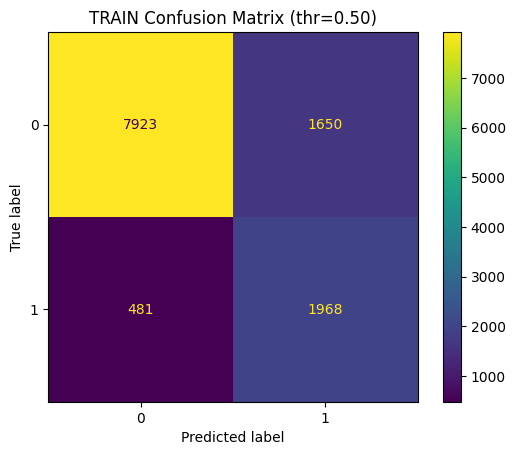

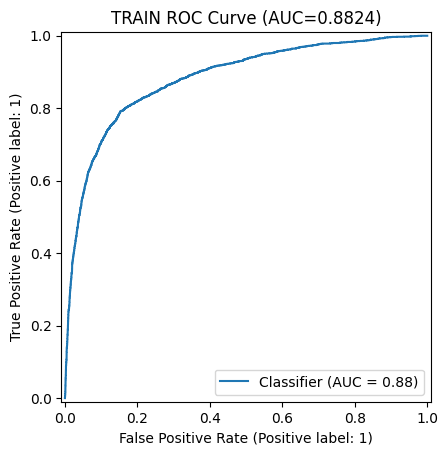

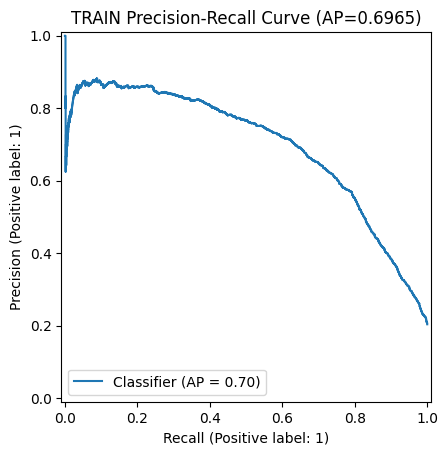

VAL AUROC: 0.8861
VAL AP (PR-AUC): 0.6908
VAL F1@0.50: 0.6509


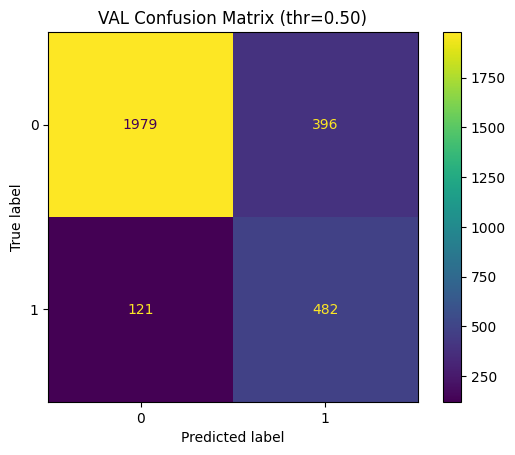

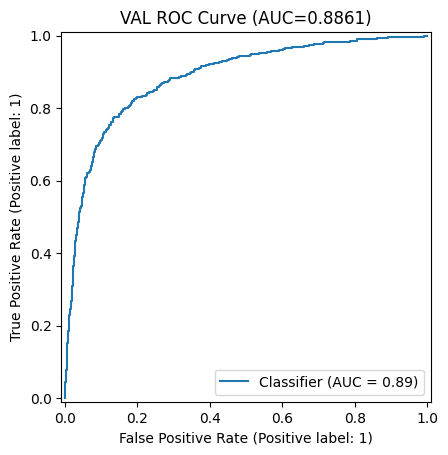

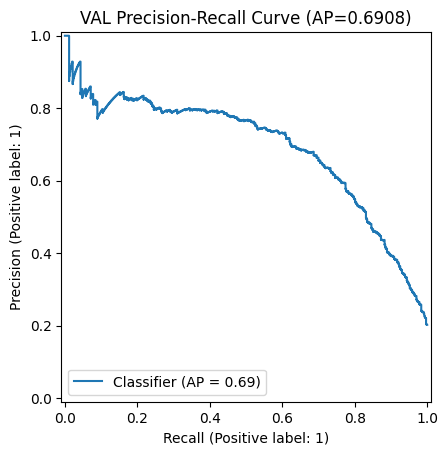

{'auroc': np.float64(0.8860609234529109),
 'ap': np.float64(0.6907972358806445),
 'f1': 0.6509115462525321,
 'threshold': 0.5}

In [15]:
evaluate_binary(model, train_inputs, train_targets, title_prefix="TRAIN")
evaluate_binary(model, val_inputs, val_targets, title_prefix="VAL")

У таргеті є дисбаланс класів (перевага Exited=0). Тому наївний бейзлайн “завжди 0” може давати непогану accuracy, але він не вміє знаходити відтік і має Recall для класу 1 ≈ 0, а отже практично не корисний для churn-задачі.
Наша модель має високий AUROC (і нормальний PR/AP), що означає: вона добре ранжує клієнтів за ймовірністю відтоку.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score

majority_class = int(train_targets.value_counts().idxmax())
print("Majority class:", majority_class)
print("Train class distribution:\n", train_targets.value_counts(normalize=True))

baseline_train_pred = np.full(shape=len(train_targets), fill_value=majority_class, dtype=int)
baseline_val_pred   = np.full(shape=len(val_targets),   fill_value=majority_class, dtype=int)

model_train_pred = model.predict(train_inputs)
model_val_pred   = model.predict(val_inputs)

acc_baseline_train = accuracy_score(train_targets, baseline_train_pred)
acc_baseline_val   = accuracy_score(val_targets, baseline_val_pred)

acc_model_train = accuracy_score(train_targets, model_train_pred)
acc_model_val   = accuracy_score(val_targets, model_val_pred)

print(f"Baseline Accuracy  - train: {acc_baseline_train:.4f} | val: {acc_baseline_val:.4f}")
print(f"LogReg  Accuracy   - train: {acc_model_train:.4f} | val: {acc_model_val:.4f}")


diff = acc_model_val - acc_baseline_val
if diff > 0.05:
    concl = "хороша (значно краще за мажоритарний бейзлайн)"
elif diff > 0.01:
    concl = "задовільна (трохи краще за бейзлайн)"
else:
    concl = "погана/сумнівна за Accuracy (майже не краще за бейзлайн; перевір ROC AUC/PR AUC)"

print("Висновок:", concl)

Majority class: 0
Train class distribution:
 Exited
0.0    0.79629
1.0    0.20371
Name: proportion, dtype: float64
Baseline Accuracy  - train: 0.7963 | val: 0.7975
LogReg  Accuracy   - train: 0.8227 | val: 0.8264
Висновок: задовільна (трохи краще за бейзлайн)


Мажоритарний бейзлайн дає ~0.798 accuracy на val. LogisticRegression дає 0.826 accuracy на val (+2.9 п.п.), тобто модель суттєво краща за тривіальну і не демонструє переобучення. За accuracy — якість задовільна; з огляду на дисбаланс класів доцільно оцінювати також ROC AUC (він високий), тому загалом модель розділяє класи добре.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [17]:
import joblib

artifact = {
    "model": model,
    "input_cols": input_cols,
    "numeric_cols": numeric_cols,
    "categorical_cols": categorical_cols,
    "target_col": target_col,
}

joblib.dump(artifact, "log_reg.joblib")
print("Saved to log_reg.joblib")

loaded = joblib.load("log_reg.joblib")
model_2 = loaded["model"]

print("Loaded model into model_2:", type(model_2))


Saved to log_reg.joblib
Loaded model into model_2: <class 'sklearn.pipeline.Pipeline'>


10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [18]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(model, input_cols, input_df: pd.DataFrame):
    """
    model: натренований sklearn Pipeline (preprocess + LogisticRegression)
    input_cols: список колонок, які подаються на вхід (без Exited, CustomerId, Surname)
    input_df: "сирий" DataFrame (як train/test)
    """
    X_input = input_df[input_cols].copy()
    prob = model.predict_proba(X_input)[:, 1]
    return prob

In [19]:
raw_df = train_inputs.copy()

In [20]:
probs = predict_raw_df(model, input_cols, raw_df[:5])
print(probs)


[0.02558726 0.11390348 0.73940352 0.71706205 0.99416873]


In [21]:
predict_raw_df(model_2, input_cols, raw_df[:5])

array([0.02558726, 0.11390348, 0.73940352, 0.71706205, 0.99416873])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [22]:
test_raw_df = pd.read_csv('/content/test.csv')
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65
9996,24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50
9997,24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72
9998,24998,15680167.0,Yermakova,595.0,France,Male,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09


In [23]:
test_raw_df["Exited"] = predict_raw_df(model_2, input_cols, test_raw_df)

test_raw_df[["Exited"]].head()

,Exited
0,0.233236
1,0.135608
2,0.413379
3,0.473732
4,0.215220


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [24]:
sample_sub = pd.read_csv('/content/sample_submission.csv')
sample_sub['Exited'] = test_raw_df['Exited'].values
print(sample_sub.head())


      id    Exited
0  15000  0.233236
1  15001  0.135608
2  15002  0.413379
3  15003  0.473732
4  15004  0.215220


In [25]:
!ls

log_reg.joblib	sample_submission.csv  submission_log_reg.csv  train.csv
sample_data	splits_parquet	       test.csv


In [27]:
sample_sub.to_csv('submission_log_reg.csv', index=False)
#

In [28]:
!ls

log_reg.joblib	sample_submission.csv  submission_log_reg.csv  train.csv
sample_data	splits_parquet	       test.csv


In [29]:
sub = pd.read_csv('submission_log_reg.csv')
sub.head()

,id,Exited
0,15000,0.233236
1,15001,0.135608
2,15002,0.413379
3,15003,0.473732
4,15004,0.215220


In [30]:
print(sub.shape)
print(sub.isna().sum())
print(sub.dtypes)
print(sub["Exited"].min(), sub["Exited"].max())
print(sub["id"].is_unique)


(10000, 2)
id        0
Exited    0
dtype: int64
id          int64
Exited    float64
dtype: object
0.0041293462359475 0.9985626739822596
True
